In [2]:
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import statistics 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
# Modelo
from tensorflow.keras.models import Sequential, Model
# Capas
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
# Redes
from tensorflow.keras.applications import ResNet50, MobileNet, DenseNet121, VGG16, Xception, EfficientNetB3, NASNetMobile, EfficientNetB2

## Tiempo por epoca

In [3]:
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)


# Parametros

In [4]:
epochs = 100
ancho = 50
alto = 50
input_shape = (ancho, alto, 1)
validation_percentage = 0.4
batch_size = 180
dropout_rate = 0.5
final_neur = 1

## Directorios

In [5]:
train_dir = r'D:\Datasets\parpadeos\train'
test_dir = r'D:\Datasets\parpadeos\test'
resultados_dir = r'C:\Users\dh_vs\Parpadeos\transferL\resultados'
rr_dir = r'C:\Users\dh_vs\Parpadeos\transferL'

In [6]:
# ResNet-50
resnet50_dir = r'C:\Users\dh_vs\Parpadeos\transferL\resnet50'

In [7]:
# MobileNet
mobile_dir = r'C:\Users\dh_vs\Parpadeos\transferL\mobilenet'

In [8]:
# Dense Net 121
dense_dir = r'C:\Users\dh_vs\Parpadeos\transferL\densenet'

In [9]:
# VGG 16
vgg_dir = r'C:\Users\dh_vs\Parpadeos\transferL\vgg16'

In [10]:
# NasNet Mobile
xception_dir = r'C:\Users\dh_vs\Parpadeos\transferL\NASNetMobile'

In [11]:
# EfiicientNet B3
efficient_dir = r'C:\Users\dh_vs\Parpadeos\transferL\efficientNetB3'

In [12]:
# Propuesto por mi
mio_dir = r'C:\Users\dh_vs\Parpadeos\transferL\mio'

In [13]:
data_dicc = {}

redes = ['EfficientNet B2', 'ResNet 50', 'MobileNet', 'DenseNet 121', 'VGG 16', 'NASNetMobile', 'Propuesto']
data_dicc['Modelos'] = redes

resultados_acc = []
key_acc = 'Test Accuracy'

resultados_time = []
key_time = 'Average Time per Epoc'

resultados_train_acc = []
key_train_acc = 'Average Train Accuracy'

resultados_loss = []
key_loss = 'Average Train Loss'

resultados_val_acc = []
key_val_acc = 'Average Val Accuracy'

resultados_val_loss = []
key_val_loss = 'Average Val Loss'

In [14]:
n_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
training_percentage = 1 - validation_percentage
training_item_count = int(n_samples*training_percentage)
validation_item_count = n_samples-int(n_samples*training_percentage)

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = validation_percentage,)
test_datagen = ImageDataGenerator(rescale = 1./255)



training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (ancho, alto),
                                                 shuffle=True,
                                                 batch_size = batch_size,
                                                 color_mode= "grayscale",
                                                 subset = "training",
                                                 class_mode='binary')


valid_set = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(ancho, alto),
                                                  shuffle=True,
                                                  batch_size = batch_size,
                                                  color_mode= "grayscale",
                                                  subset = "validation",
                                                  class_mode="binary")  


test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (ancho, alto),
                                            batch_size = batch_size,
                                            color_mode= "grayscale",
                                            class_mode='binary')

Found 49412 images belonging to 2 classes.
Found 32940 images belonging to 2 classes.
Found 2994 images belonging to 2 classes.


## Dividir B.D. en Entrenamiento, validacion y prueba

In [16]:
training_set.class_indices

{'ojo_a': 0, 'ojo_c': 1}

# EfficientNet-B2 

## Modelo

In [ ]:
base_efficientNetB3 = EfficientNetB2(weights=None,
                            include_top = False,
                            input_shape = input_shape)


inputs = Input(shape=input_shape)
base_efficientNetB3 = base_efficientNetB3(inputs)
pooling = layers.GlobalAveragePooling2D()(base_efficientNetB3)
outputs = Dense(units = final_neur, activation = 'sigmoid')(pooling)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#### Callbacks

In [ ]:
efficientNetB3_times = TimingCallback()


acc_model_filename = 'efficientNetB3_best_accuracy.h5'
acc_checkpoint_path = os.path.join(efficient_dir, acc_model_filename)

efficientNetB3_accuracy = [ModelCheckpoint(filepath=acc_checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True)]

loss_model_filename = 'efficientNetB3_loss.h5'
loss_checkpoint_path = os.path.join(efficient_dir, loss_model_filename)

efficientNetB3_loss = [ModelCheckpoint(filepath=loss_checkpoint_path, monitor='val_loss', mode='min', save_best_only=True)]


## Entrenamiento

In [ ]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=valid_set.n//valid_set.batch_size

history = model.fit_generator(training_set,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             epochs = epochs,
                             validation_data = valid_set,    
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[efficientNetB3_times, efficientNetB3_accuracy, efficientNetB3_loss])

## Tiempo de Ejecución

In [ ]:
epocas = []
efficientNetB3_eptime = efficientNetB3_times.logs
for i in range(len(efficientNetB3_eptime)):
    epocas.append(i + 1)

In [ ]:
acc = history.history['accuracy']
mean_acc = statistics.mean(acc)
resultados_train_acc.append(mean_acc)

loss = history.history['loss']
mean_loss = statistics.mean(loss)
resultados_loss.append(mean_loss)

val_acc = history.history['val_accuracy']
mean_val_acc = statistics.mean(val_acc)
resultados_val_acc.append(mean_val_acc)

val_loss = history.history['val_loss']
mean_val_loss = statistics.mean(val_loss)
resultados_val_loss.append(mean_val_loss)

mean_time = statistics.mean(efficientNetB3_times.logs)

datos = list(zip(epocas, efficientNetB3_eptime, acc, loss, val_acc, val_loss))
efficientNetB3_df = pd.DataFrame(datos, columns = ['Epoca', 'Tiempo', 'Accuracy', 'Loss', 'Val Accuracy', 'Val Loss'])


new_row = {'Epoca': 'Promedios', 'Tiempo': mean_time, 'Accuracy': mean_acc, 'Loss': mean_loss, 'Val Accuracy': mean_val_acc, 'Val Loss': mean_val_loss}
efficientNetB3_df = efficientNetB3_df.append(new_row, ignore_index=True)
resultados_time.append(mean_time)
print(efficientNetB3_df)
ef_dir = os.path.join(efficient_dir, 'efficientNetB3.csv')
efficientNetB3_df.to_csv(ef_dir, index = False)

In [ ]:
fig = plt.figure()
plt.plot(epocas, efficientNetB3_eptime)
plt.title('EfficientNetB2, Tiempo por epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
ef_dir = os.path.join(efficient_dir, 'efficientNetB2_time.png')
fig.savefig(ef_dir)

### Eliminando el primer dato

In [ ]:
fig = plt.figure()
plt.plot(epocas[1:], efficientNetB3_eptime[1:])
plt.title('EfficientNetB2, Tiempo por epoca, eliminando primer epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
ef_dir = os.path.join(efficient_dir, 'efficientNetB2_time2.png')
fig.savefig(ef_dir)

## Proceso de Entrenamiento

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss en epocas - efficientNetB2')
plt.ylabel('Loss')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
ef_dir = os.path.join(efficient_dir, 'entrena_loss_efficientNetB2.png')
fig.savefig(ef_dir)

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy en epocas - efficientNetB2')
plt.ylabel('accuracy')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
ef_dir = os.path.join(efficient_dir, 'entrena_accuracy_efficientNetB2.png')
fig.savefig(ef_dir)

## Prueba

In [ ]:
model = keras.models.load_model(acc_checkpoint_path)
acc_result = model.evaluate(test_set)
result_acc = acc_result[1]*100
print(result_acc)
print(acc_checkpoint_path)

model = keras.models.load_model(loss_checkpoint_path)
loss_result = model.evaluate(test_set)
result_loss = loss_result[1]*100
print(result_loss)
print(loss_checkpoint_path)

In [ ]:
if result_acc >= result_loss:
    final_model = keras.models.load_model(acc_checkpoint_path)
    result = result_acc
    resultados_acc.append(result)
    print('acc')
else:
    final_model = keras.models.load_model(loss_checkpoint_path)
    result = result_loss
    resultados_acc.append(result)
    print('loss')

# ResNet 50

## Modelo

In [ ]:
base_resnet50 = ResNet50(weights=None,
                            include_top = False,
                            input_shape = input_shape)


inputs = Input(shape=input_shape)
base_resnet50 = base_resnet50(inputs)
pooling = layers.GlobalAveragePooling2D()(base_resnet50)
outputs = Dense(units = final_neur, activation = 'sigmoid')(pooling)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#### Callbacks

In [ ]:
resnet_times = TimingCallback()


acc_model_filename = 'rn50_best_accuracy.h5'
acc_checkpoint_path = os.path.join(resnet50_dir, acc_model_filename)

resnet_accuracy = [ModelCheckpoint(filepath=acc_checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True)]

loss_model_filename = 'rn50_best_loss.h5'
loss_checkpoint_path = os.path.join(resnet50_dir, loss_model_filename)

resnet_loss = [ModelCheckpoint(filepath=loss_checkpoint_path, monitor='val_loss', mode='min', save_best_only=True)]


### Entrenamiento

In [ ]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=valid_set.n//valid_set.batch_size

history = model.fit_generator(training_set,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             epochs = epochs,
                             validation_data = valid_set,    
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[resnet_times, resnet_accuracy, resnet_loss])

### Tiempo de ejecución

In [ ]:
epocas = []
resnet_eptime = resnet_times.logs
for i in range(len(resnet_eptime)):
    epocas.append(i + 1)

In [ ]:
acc = history.history['accuracy']
mean_acc = statistics.mean(acc)
resultados_train_acc.append(mean_acc)

loss = history.history['loss']
mean_loss = statistics.mean(loss)
resultados_loss.append(mean_loss)

val_acc = history.history['val_accuracy']
mean_val_acc = statistics.mean(val_acc)
resultados_val_acc.append(mean_val_acc)

val_loss = history.history['val_loss']
mean_val_loss = statistics.mean(val_loss)
resultados_val_loss.append(mean_val_loss)

mean_time = statistics.mean(resnet_times.logs)

datos = list(zip(epocas, resnet_eptime, acc, loss, val_acc, val_loss))
resnet_df = pd.DataFrame(datos, columns = ['Epoca', 'Tiempo', 'Accuracy', 'Loss', 'Val Accuracy', 'Val Loss'])


new_row = {'Epoca': 'Promedios', 'Tiempo': mean_time, 'Accuracy': mean_acc, 'Loss': mean_loss, 'Val Accuracy': mean_val_acc, 'Val Loss': mean_val_loss}
resnet_df = resnet_df.append(new_row, ignore_index=True)
resultados_time.append(mean_time)
print(resnet_df)
r_path = os.path.join(resnet50_dir, 'resnet50.csv')
resnet_df.to_csv(r_path, index = False)

In [ ]:
fig = plt.figure()
plt.plot(epocas, resnet_eptime)
plt.title('ResNet-50, Tiempo por epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
r_path = os.path.join(resnet50_dir, 'resnet_time.png')
fig.savefig(r_path)

### Eliminando el primer dato

In [ ]:
fig = plt.figure()
plt.plot(epocas[1:], resnet_eptime[1:])
plt.title('ResNet-50, Tiempo por epoca, eliminando primer epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
r_path = os.path.join(resnet50_dir, 'resnet_time2.png')
fig.savefig(r_path)

### Proceso de Entrenamiento

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss en epocas - ResNet-50')
plt.ylabel('Loss')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
r_path = os.path.join(resnet50_dir, 'entrena_loss_resnet.png')
fig.savefig(r_path)

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy en epocas - ResNet-50')
plt.ylabel('accuracy')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
r_path = os.path.join(resnet50_dir, 'entrada_accuracy_resnet.png')
fig.savefig(r_path)

### Prueba

In [ ]:
model = keras.models.load_model(acc_checkpoint_path)
acc_result = model.evaluate(test_set)
result_acc = acc_result[1]*100
print(result_acc)
print(acc_checkpoint_path)

model = keras.models.load_model(loss_checkpoint_path)
loss_result = model.evaluate(test_set)
result_loss = loss_result[1]*100
print(result_loss)
print(loss_checkpoint_path)

In [ ]:
if result_acc >= result_loss:
    final_model = keras.models.load_model(acc_checkpoint_path)
    result = result_acc
    resultados_acc.append(result)
    print('acc')
else:
    final_model = keras.models.load_model(loss_checkpoint_path)
    result = result_loss
    resultados_acc.append(result)
    print('loss')

# MobileNet

## Modelo

In [ ]:
base_mobilenet = MobileNet(weights=None,
                            include_top = False,
                            input_shape = input_shape)


inputs = Input(shape=input_shape)
base_mobilenet = base_mobilenet(inputs)
pooling = layers.GlobalAveragePooling2D()(base_mobilenet)
outputs = Dense(units = final_neur, activation = 'sigmoid')(pooling)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#### Callbacks

In [ ]:
mobilenet_times = TimingCallback()


acc_model_filename = 'mobilenet_best_accuracy.h5'
acc_checkpoint_path = os.path.join(mobile_dir, acc_model_filename)

mobilenet_accuracy = [ModelCheckpoint(filepath=acc_checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True)]

loss_model_filename = 'mobilenet_best_loss.h5'
loss_checkpoint_path = os.path.join(mobile_dir, loss_model_filename)

mobilenet_loss = [ModelCheckpoint(filepath=loss_checkpoint_path, monitor='val_loss', mode='min', save_best_only=True)]


## Entrenamiento

In [ ]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=valid_set.n//valid_set.batch_size

history = model.fit_generator(training_set,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             epochs = epochs,
                             validation_data = valid_set,    
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[mobilenet_times, mobilenet_accuracy, mobilenet_loss])

## Tiempo de Ejecución 

In [ ]:
epocas = []
mobilenet_eptime = mobilenet_times.logs
for i in range(len(mobilenet_eptime)):
    epocas.append(i + 1)

In [ ]:
acc = history.history['accuracy']
mean_acc = statistics.mean(acc)
resultados_train_acc.append(mean_acc)

loss = history.history['loss']
mean_loss = statistics.mean(loss)
resultados_loss.append(mean_loss)

val_acc = history.history['val_accuracy']
mean_val_acc = statistics.mean(val_acc)
resultados_val_acc.append(mean_val_acc)

val_loss = history.history['val_loss']
mean_val_loss = statistics.mean(val_loss)
resultados_val_loss.append(mean_val_loss)

mean_time = statistics.mean(mobilenet_times.logs)

datos = list(zip(epocas, mobilenet_eptime, acc, loss, val_acc, val_loss))
mobilenet_df = pd.DataFrame(datos, columns = ['Epoca', 'Tiempo', 'Accuracy', 'Loss', 'Val Accuracy', 'Val Loss'])


new_row = {'Epoca': 'Promedios', 'Tiempo': mean_time, 'Accuracy': mean_acc, 'Loss': mean_loss, 'Val Accuracy': mean_val_acc, 'Val Loss': mean_val_loss}
mobilenet_df = mobilenet_df.append(new_row, ignore_index=True)
resultados_time.append(mean_time)
print(mobilenet_df)
m_dir = os.path.join(mobile_dir, 'mobilenet.csv')
mobilenet_df.to_csv(m_dir, index = False)

In [ ]:
fig = plt.figure()
plt.plot(epocas, mobilenet_eptime)
plt.title('mobilenet, Tiempo por epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
m_dir = os.path.join(mobile_dir, 'mobilenet_time.png')
fig.savefig(m_dir)

### Eliminando el primer dato

In [ ]:
fig = plt.figure()
plt.plot(epocas[1:], mobilenet_eptime[1:])
plt.title('mobilenet, Tiempo por epoca, eliminando primer epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
m_dir = os.path.join(mobile_dir, 'mobilenet_time2.png')
fig.savefig(m_dir)

## Proceso de Entrenamiento

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss en epocas - MobileNet')
plt.ylabel('Loss')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
m_dir = os.path.join(mobile_dir, 'entrena_loss_mobilenet.png')
fig.savefig(m_dir)

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy en epocas - MobileNet')
plt.ylabel('accuracy')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
m_dir = os.path.join(mobile_dir, 'entrena_accuracy_mobilenet.png')
fig.savefig(m_dir)

## Prueba

In [ ]:
model = keras.models.load_model(acc_checkpoint_path)
acc_result = model.evaluate(test_set)
result_acc = acc_result[1]*100
print(result_acc)
print(acc_checkpoint_path)

model = keras.models.load_model(loss_checkpoint_path)
loss_result = model.evaluate(test_set)
result_loss = loss_result[1]*100
print(result_loss)
print(loss_checkpoint_path)

In [ ]:
if result_acc >= result_loss:
    final_model = keras.models.load_model(acc_checkpoint_path)
    result = result_acc
    resultados_acc.append(result)
    print('acc')
else:
    final_model = keras.models.load_model(loss_checkpoint_path)
    result = result_loss
    resultados_acc.append(result)
    print('loss')

# DenseNet 121

## Modelo

In [ ]:
base_densenet = DenseNet121(weights=None,
                            include_top = False,
                            input_shape = input_shape)


inputs = Input(shape=input_shape)
base_densenet = base_densenet(inputs)
pooling = layers.GlobalAveragePooling2D()(base_densenet)
outputs = Dense(units = final_neur, activation = 'sigmoid')(pooling)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#### Callbacks

In [ ]:
densenet_times = TimingCallback()


acc_model_filename = 'densenet_best_accuracy.h5'
acc_checkpoint_path = os.path.join(dense_dir, acc_model_filename)

densenet_accuracy = [ModelCheckpoint(filepath=acc_checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True)]

loss_model_filename = 'densenet_best_loss.h5'
loss_checkpoint_path = os.path.join(dense_dir, loss_model_filename)

densenet_loss = [ModelCheckpoint(filepath=loss_checkpoint_path, monitor='val_loss', mode='min', save_best_only=True)]


## Entrenamiento

In [ ]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=valid_set.n//valid_set.batch_size

history = model.fit_generator(training_set,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             epochs = epochs,
                             validation_data = valid_set,    
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[densenet_times, densenet_accuracy, densenet_loss])

## Tiempo de Ejecución

In [ ]:
epocas = []
densenet_eptime = densenet_times.logs
for i in range(len(densenet_eptime)):
    epocas.append(i + 1)

In [ ]:
acc = history.history['accuracy']
mean_acc = statistics.mean(acc)
resultados_train_acc.append(mean_acc)

loss = history.history['loss']
mean_loss = statistics.mean(loss)
resultados_loss.append(mean_loss)

val_acc = history.history['val_accuracy']
mean_val_acc = statistics.mean(val_acc)
resultados_val_acc.append(mean_val_acc)

val_loss = history.history['val_loss']
mean_val_loss = statistics.mean(val_loss)
resultados_val_loss.append(mean_val_loss)

mean_time = statistics.mean(densenet_times.logs)

datos = list(zip(epocas, densenet_eptime, acc, loss, val_acc, val_loss))
densenet_df = pd.DataFrame(datos, columns = ['Epoca', 'Tiempo', 'Accuracy', 'Loss', 'Val Accuracy', 'Val Loss'])


new_row = {'Epoca': 'Promedios', 'Tiempo': mean_time, 'Accuracy': mean_acc, 'Loss': mean_loss, 'Val Accuracy': mean_val_acc, 'Val Loss': mean_val_loss}
densenet_df = densenet_df.append(new_row, ignore_index=True)
resultados_time.append(mean_time)
print(densenet_df)
d_dir = os.path.join(dense_dir, 'densenet.csv')
densenet_df.to_csv(d_dir, index = False)

In [ ]:
fig = plt.figure()
plt.plot(epocas, densenet_eptime)
plt.title('densenet, Tiempo por epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
d_dir = os.path.join(dense_dir, 'densenet_time.png')
fig.savefig(d_dir)

### Eliminando el primer dato

In [ ]:
fig = plt.figure()
plt.plot(epocas[1:], densenet_eptime[1:])
plt.title('densenet, Tiempo por epoca, eliminando primer epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
d_dir = os.path.join(dense_dir, 'densenet_time2.png')
fig.savefig(d_dir)

## Proceso de Entrenamiento

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss en epocas - DenseNet 121')
plt.ylabel('Loss')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
d_dir = os.path.join(dense_dir, 'entrena_loss_densenet.png')
fig.savefig(d_dir)

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy en epocas - DenseNet 121')
plt.ylabel('accuracy')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
d_dir = os.path.join(dense_dir, 'entrena_accuracy_densenet.png')
fig.savefig(d_dir)

## Prueba

In [ ]:
model = keras.models.load_model(acc_checkpoint_path)
acc_result = model.evaluate(test_set)
result_acc = acc_result[1]*100
print(result_acc)
print(acc_checkpoint_path)

model = keras.models.load_model(loss_checkpoint_path)
loss_result = model.evaluate(test_set)
result_loss = loss_result[1]*100
print(result_loss)
print(loss_checkpoint_path)

In [ ]:
if result_acc >= result_loss:
    final_model = keras.models.load_model(acc_checkpoint_path)
    result = result_acc
    resultados_acc.append(result)
    print('acc')
else:
    final_model = keras.models.load_model(loss_checkpoint_path)
    result = result_loss
    resultados_acc.append(result)
    print('loss')

# VGG 16

## Modelo

In [ ]:
base_vgg16 = VGG16(weights=None,
                   include_top = False,
                   input_shape = input_shape)


inputs = Input(shape=input_shape)
base_vgg16 = base_vgg16(inputs)
pooling = layers.GlobalAveragePooling2D()(base_vgg16)
outputs = Dense(units = final_neur, activation = 'sigmoid')(pooling)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#### Callbacks

In [ ]:
vgg16_times = TimingCallback()


acc_model_filename = 'vgg16_best_accuracy.h5'
acc_checkpoint_path = os.path.join(vgg_dir, acc_model_filename)

vgg16_accuracy = [ModelCheckpoint(filepath=acc_checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True)]

loss_model_filename = 'vgg16_best_loss.h5'
loss_checkpoint_path = os.path.join(vgg_dir, loss_model_filename)

vgg16_loss = [ModelCheckpoint(filepath=loss_checkpoint_path, monitor='val_loss', mode='min', save_best_only=True)]


## Entrenamiento

In [ ]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=valid_set.n//valid_set.batch_size

history = model.fit_generator(training_set,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             epochs = epochs,
                             validation_data = valid_set,    
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[vgg16_times, vgg16_accuracy, vgg16_loss])

## Tiempo de Ejecución

In [ ]:
epocas = []
vgg16_eptime = vgg16_times.logs
for i in range(len(vgg16_eptime)):
    epocas.append(i + 1)

In [ ]:
acc = history.history['accuracy']
mean_acc = statistics.mean(acc)
resultados_train_acc.append(mean_acc)

loss = history.history['loss']
mean_loss = statistics.mean(loss)
resultados_loss.append(mean_loss)

val_acc = history.history['val_accuracy']
mean_val_acc = statistics.mean(val_acc)
resultados_val_acc.append(mean_val_acc)

val_loss = history.history['val_loss']
mean_val_loss = statistics.mean(val_loss)
resultados_val_loss.append(mean_val_loss)

mean_time = statistics.mean(vgg16_times.logs)

datos = list(zip(epocas, vgg16_eptime, acc, loss, val_acc, val_loss))
vgg16_df = pd.DataFrame(datos, columns = ['Epoca', 'Tiempo', 'Accuracy', 'Loss', 'Val Accuracy', 'Val Loss'])


new_row = {'Epoca': 'Promedios', 'Tiempo': mean_time, 'Accuracy': mean_acc, 'Loss': mean_loss, 'Val Accuracy': mean_val_acc, 'Val Loss': mean_val_loss}
vgg16_df = vgg16_df.append(new_row, ignore_index=True)
resultados_time.append(mean_time)
print(vgg16_df)
v_dir = os.path.join(vgg_dir, 'vgg16.csv')
vgg16_df.to_csv(v_dir, index = False)

In [ ]:
fig = plt.figure()
plt.plot(epocas, vgg16_eptime)
plt.title('vgg16, Tiempo por epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
v_dir = os.path.join(vgg_dir, 'vgg16_time.png')
fig.savefig(v_dir)

### Eliminando el primer dato

In [ ]:
fig = plt.figure()
plt.plot(epocas[1:], vgg16_eptime[1:])
plt.title('vgg16, Tiempo por epoca, eliminando primer epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
v_dir = os.path.join(vgg_dir, 'vgg16_time2.png')
fig.savefig(v_dir)

## Proceso de Entrenamiento

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss en epocas - VGG 16')
plt.ylabel('Loss')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
v_dir = os.path.join(vgg_dir, 'entrena_loss_vgg16.png')
fig.savefig(v_dir)

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy en epocas - VGG 16')
plt.ylabel('accuracy')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
v_dir = os.path.join(vgg_dir, 'entrena_accuracy_vgg16.png')
fig.savefig(v_dir)

## Prueba

In [ ]:
model = keras.models.load_model(acc_checkpoint_path)
acc_result = model.evaluate(test_set)
result_acc = acc_result[1]*100
print(result_acc)
print(acc_checkpoint_path)

model = keras.models.load_model(loss_checkpoint_path)
loss_result = model.evaluate(test_set)
result_loss = loss_result[1]*100
print(result_loss)
print(loss_checkpoint_path)

In [ ]:
if result_acc >= result_loss:
    final_model = keras.models.load_model(acc_checkpoint_path)
    result = result_acc
    resultados_acc.append(result)
    print('acc')
else:
    final_model = keras.models.load_model(loss_checkpoint_path)
    result = result_loss
    resultados_acc.append(result)
    print('loss')

# NASNetMobile

## Modelo

In [17]:
base_xception = NASNetMobile(weights=None,
                            include_top = False,
                            input_shape = input_shape)


inputs = Input(shape=input_shape)
base_xception = base_xception(inputs)
pooling = layers.GlobalAveragePooling2D()(base_xception)
outputs = Dense(units = final_neur, activation = 'sigmoid')(pooling)
model = Model(inputs=inputs, outputs=outputs)
    
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 50, 1)]       0         
_________________________________________________________________
NASNet (Functional)          (None, 2, 2, 1056)        4269140   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1057      
Total params: 4,270,197
Trainable params: 4,233,459
Non-trainable params: 36,738
_________________________________________________________________


In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#### Callbacks

In [19]:
xception_times = TimingCallback()


acc_model_filename = 'NASNetMobile_best_accuracy.h5'
acc_checkpoint_path = os.path.join(xception_dir, acc_model_filename)

xception_accuracy = [ModelCheckpoint(filepath=acc_checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True)]

loss_model_filename = 'NASNetMobile_loss.h5'
loss_checkpoint_path = os.path.join(xception_dir, loss_model_filename)

xception_loss = [ModelCheckpoint(filepath=loss_checkpoint_path, monitor='val_loss', mode='min', save_best_only=True)]


## Entrenamiento

In [20]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=valid_set.n//valid_set.batch_size

history = model.fit_generator(training_set,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             epochs = epochs,
                             validation_data = valid_set,    
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[xception_times, xception_accuracy, xception_loss])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
274/274 [==============================] - 78s 284ms/step - loss: 0.1575 - accuracy: 0.9396 - val_loss: 0.7413 - val_accuracy: 0.6751
Epoch 2/100
274/274 [==============================] - 74s 271ms/step - loss: 0.0773 - accuracy: 0.9717 - val_loss: 0.7272 - val_accuracy: 0.5047
Epoch 3/100
274/274 [==============================] - 74s 272ms/step - loss: 0.0622 - accuracy: 0.9768 - val_loss: 0.8260 - val_accuracy: 0.50640.0643 - accuracy: - ETA: 13s - loss: 0.0640 - a - ETA: 10s - loss: 0.0
Epoch 4/100
274/274 [==============================] - 96s 349ms/step - loss: 0.0535 - accuracy: 0.9803 - val_loss: 1.0421 - val_accuracy: 0.49667s - loss: 0.0554 - accuracy: 0.9 - ETA: 37s - loss: 0.0555 - accuracy - ETA: 36s - loss: 0.0555 - accuracy:  - ETA: 35s - loss: 0.0549 - accur - ETA: 33s - loss: 0.0543 - accuracy: 0. -  - ETA - ETA: 5s - loss: 0.0 - ETA: 2s - l
Epoch 5/100
274/274 [===================

274/274 [==============================] - 75s 275ms/step - loss: 0.0185 - accuracy: 0.9933 - val_loss: 1.9050 - val_accuracy: 0.9128 ETA: 19s - loss: 0.01
Epoch 47/100
274/274 [==============================] - 76s 276ms/step - loss: 0.0174 - accuracy: 0.9934 - val_loss: 3.4795 - val_accuracy: 0.8454 37s - - ETA: 32s - loss: 0.0189 - accura - ETA: 22s - loss: 0.0183 - a - ETA: 19s - loss: 0.01 - ETA: 15s - loss: 0 - ETA: 11s - loss: 0.0177 -  - ETA: 4s - loss: 0.0176 -  - ETA: 3s - loss: 0.0176 - accuracy: 0. - ETA: 2s -
Epoch 48/100
274/274 [==============================] - 77s 280ms/step - loss: 0.0183 - accuracy: 0.9931 - val_loss: 3.5260 - val_accuracy: 0.8677accur - ETA: 23s - loss: 0.0160 - accuracy: 0.993 - ETA: 23s - ETA: 16s - loss: 0.0162 - accuracy: 0.993 - ETA: 16s - loss: 0.0164 - a - ETA: 13s - loss: 0.0169 - accu - ETA: 11s - loss: 0.0172 - acc - ETA: 5s - loss: 0.0178 - accuracy: 0.99 - ETA: 5s - loss: 0.0179 -  - ETA: 3s - loss: 0.0180 - accuracy:  - ETA: 2s - loss: 

274/274 [==============================] - 77s 282ms/step - loss: 0.0127 - accuracy: 0.9947 - val_loss: 5.0188 - val_accuracy: 0.8730 loss: 0.0124 - accurac - ETA: 41s - loss: 0.0124 - accuracy: 0.994 - ETA: 40 - ETA: 18s - loss: 0.0130 - accuracy: 0. - ETA: 17s - loss: 0.0130 - accuracy: 0. - ETA: 16s -  - ETA: 10s - loss: 0.0129 - accuracy: 0.9 - - ETA: 1s - loss: 0.0129 
Epoch 90/100
274/274 [==============================] - 75s 275ms/step - loss: 0.0122 - accuracy: 0.9955 - val_loss: 1.5425 - val_accuracy: 0.9194 loss: 0.0121 - accuracy: 0.995 - ETA:  - ETA: 25s - loss: 0.0119 - - ETA: 22s - loss: 0.0119 - accuracy: 0 - ETA: 21s -  - ETA: 15s - loss: 0.0118 - acc  - ETA: 7s - loss: 0.0 - ETA: 5s - loss: 0.0122 - ac - ETA: 3s - loss: 0.0122 - accura - ETA: 2s - loss: 0.0122 - accu - ETA: 1s - loss: 0.0122 - accuracy:  - ETA: 1s - loss: 0.0122 - ac
Epoch 91/100
274/274 [==============================] - 75s 274ms/step - loss: 0.0113 - accuracy: 0.9955 - val_loss: 2.0629 - val_accura

## Tiempo de Ejecución

In [21]:
epocas = []
xception_eptime = xception_times.logs
for i in range(len(xception_eptime)):
    epocas.append(i + 1)

In [22]:
acc = history.history['accuracy']
mean_acc = statistics.mean(acc)
resultados_train_acc.append(mean_acc)

loss = history.history['loss']
mean_loss = statistics.mean(loss)
resultados_loss.append(mean_loss)

val_acc = history.history['val_accuracy']
mean_val_acc = statistics.mean(val_acc)
resultados_val_acc.append(mean_val_acc)

val_loss = history.history['val_loss']
mean_val_loss = statistics.mean(val_loss)
resultados_val_loss.append(mean_val_loss)

mean_time = statistics.mean(xception_times.logs)

datos = list(zip(epocas, xception_eptime, acc, loss, val_acc, val_loss))
xception_df = pd.DataFrame(datos, columns = ['Epoca', 'Tiempo', 'Accuracy', 'Loss', 'Val Accuracy', 'Val Loss'])


new_row = {'Epoca': 'Promedios', 'Tiempo': mean_time, 'Accuracy': mean_acc, 'Loss': mean_loss, 'Val Accuracy': mean_val_acc, 'Val Loss': mean_val_loss}
xception_df = xception_df.append(new_row, ignore_index=True)
resultados_time.append(mean_time)
print(xception_df)
x_dir = os.path.join(xception_dir, 'NASNetMobile.csv')
xception_df.to_csv(x_dir, index = False)

         Epoca     Tiempo  Accuracy      Loss  Val Accuracy   Val Loss
0            1  90.853170  0.939572  0.157465      0.675076   0.741257
1            2  73.334456  0.971665  0.077334      0.504736   0.727196
2            3  74.808071  0.976763  0.062240      0.506436   0.825993
3            4  95.933137  0.980318  0.053471      0.496600   1.042115
4            5  86.829142  0.982999  0.046669      0.496600   1.414491
..         ...        ...       ...       ...           ...        ...
96          97  76.772937  0.995917  0.010650      0.813692   3.675037
97          98  76.022418  0.995775  0.010915      0.866454   2.588970
98          99  76.594169  0.995734  0.011311      0.872890   1.874995
99         100  75.881556  0.995531  0.010933      0.855525   3.388901
100  Promedios  79.031728  0.991542  0.022930      0.731163  57.407581

[101 rows x 6 columns]


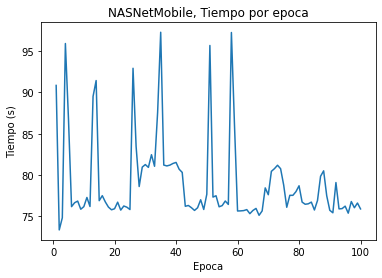

In [23]:
fig = plt.figure()
plt.plot(epocas, xception_eptime)
plt.title('NASNetMobile, Tiempo por epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
x_dir = os.path.join(xception_dir, 'NASNetMobile_time.png')
fig.savefig(x_dir)

### Eliminando el primer dato

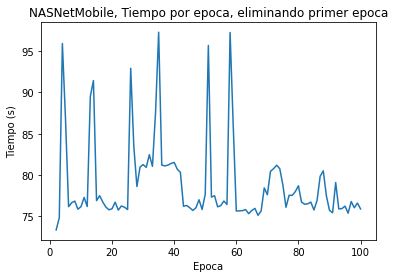

In [24]:
fig = plt.figure()
plt.plot(epocas[1:], xception_eptime[1:])
plt.title('NASNetMobile, Tiempo por epoca, eliminando primer epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
x_dir = os.path.join(xception_dir, 'NASNetMobile_time2.png')
fig.savefig(x_dir)

# Proceso de Entrenamiento

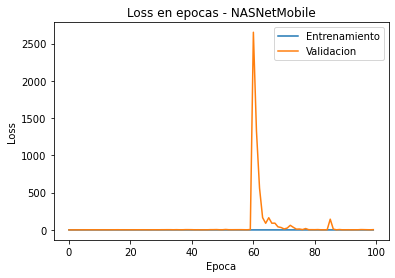

In [25]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss en epocas - NASNetMobile')
plt.ylabel('Loss')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
x_dir = os.path.join(xception_dir, 'entrena_loss_NASNetMobile.png')
fig.savefig(x_dir)

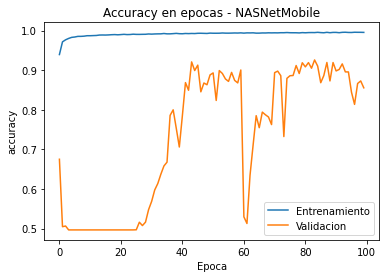

In [26]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy en epocas - NASNetMobile')
plt.ylabel('accuracy')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
x_dir = os.path.join(xception_dir, 'entrena_accuracy_NASNetMobile.png')
fig.savefig(x_dir)

## Prueba

In [27]:
model = keras.models.load_model(acc_checkpoint_path)
acc_result = model.evaluate(test_set)
result_acc = acc_result[1]*100
print(result_acc)
print(acc_checkpoint_path)

model = keras.models.load_model(loss_checkpoint_path)
loss_result = model.evaluate(test_set)
result_loss = loss_result[1]*100
print(result_loss)
print(loss_checkpoint_path)

17/17 [==============================] - 2s 140ms/step - loss: 1.3027 - accuracy: 0.9272
92.71876811981201
C:\Users\dh_vs\Tesis\Parpadeos\transferL\NASNetMobile\NASNetMobile_best_accuracy.h5
17/17 [==============================] - 1s 63ms/step - loss: 0.7046 - accuracy: 0.5150
51.50300860404968
C:\Users\dh_vs\Tesis\Parpadeos\transferL\NASNetMobile\NASNetMobile_loss.h5


In [28]:
if result_acc >= result_loss:
    final_model = keras.models.load_model(acc_checkpoint_path)
    result = result_acc
    resultados_acc.append(result)
    print('acc')
else:
    final_model = keras.models.load_model(loss_checkpoint_path)
    result = result_loss
    resultados_acc.append(result)
    print('loss')

acc


# Propuesto por Mi

## Modelo

In [ ]:
model = Sequential()

model.add(Input(shape = (ancho, alto, 1)))
model.add(Conv2D(32, (4,4), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(8, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(dropout_rate))
model.add(Dense(40, activation = 'relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(12, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#### Callbacks

In [ ]:
propuesto_times = TimingCallback()


acc_model_filename = 'propuesto_best_accuracy.h5'
acc_checkpoint_path = os.path.join(mio_dir, acc_model_filename)

propuesto_accuracy = [ModelCheckpoint(filepath=acc_checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True)]

loss_model_filename = 'propuesto_loss.h5'
loss_checkpoint_path = os.path.join(mio_dir, loss_model_filename)

propuesto_loss = [ModelCheckpoint(filepath=loss_checkpoint_path, monitor='val_loss', mode='min', save_best_only=True)]


## Entrenamiento

In [ ]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=valid_set.n//valid_set.batch_size

history = model.fit_generator(training_set,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             epochs = epochs,
                             validation_data = valid_set,    
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[propuesto_times, propuesto_accuracy, propuesto_loss])

## Tiempo de Ejecuación

In [ ]:
epocas = []
propuesto_eptime = propuesto_times.logs
for i in range(len(propuesto_eptime)):
    epocas.append(i + 1)

In [ ]:
acc = history.history['accuracy']
mean_acc = statistics.mean(acc)
resultados_train_acc.append(mean_acc)

loss = history.history['loss']
mean_loss = statistics.mean(loss)
resultados_loss.append(mean_loss)

val_acc = history.history['val_accuracy']
mean_val_acc = statistics.mean(val_acc)
resultados_val_acc.append(mean_val_acc)

val_loss = history.history['val_loss']
mean_val_loss = statistics.mean(val_loss)
resultados_val_loss.append(mean_val_loss)

mean_time = statistics.mean(propuesto_times.logs)

datos = list(zip(epocas, propuesto_eptime, acc, loss, val_acc, val_loss))
propuesto_df = pd.DataFrame(datos, columns = ['Epoca', 'Tiempo', 'Accuracy', 'Loss', 'Val Accuracy', 'Val Loss'])


new_row = {'Epoca': 'Promedios', 'Tiempo': mean_time, 'Accuracy': mean_acc, 'Loss': mean_loss, 'Val Accuracy': mean_val_acc, 'Val Loss': mean_val_loss}
propuesto_df = propuesto_df.append(new_row, ignore_index=True)
resultados_time.append(mean_time)
print(propuesto_df)
m_dir = os.path.join(mio_dir, 'propuesto.csv')
propuesto_df.to_csv(m_dir, index = False)

In [ ]:
fig = plt.figure()
plt.plot(epocas, propuesto_eptime)
plt.title('propuesto, Tiempo por epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
m_dir = os.path.join(mio_dir, 'propuesto_time.png')
fig.savefig(m_dir)

### Eliminando el primer dato

In [ ]:
fig = plt.figure()
plt.plot(epocas[1:], propuesto_eptime[1:])
plt.title('propuesto, Tiempo por epoca, eliminando primer epoca')
plt.xlabel('Epoca')
plt.ylabel('Tiempo (s)')
plt.show()
m_dir = os.path.join(mio_dir, 'propuesto_time2.png')
fig.savefig(m_dir)

## Proceso de Entrenamiento

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss en epocas - Propuesto')
plt.ylabel('Loss')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
m_dir = os.path.join(mio_dir, 'entrena_loss_propuesto.png')
fig.savefig(m_dir)

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy en epocas - Propuesto')
plt.ylabel('accuracy')
plt.xlabel('Epoca')
plt.legend(['Entrenamiento', 'Validacion'], loc='best')
plt.show()
m_dir = os.path.join(mio_dir, 'entrena_accuracy_propuesto.png')
fig.savefig(m_dir)

## Prueba

In [ ]:
model = keras.models.load_model(acc_checkpoint_path)
acc_result = model.evaluate(test_set)
result_acc = acc_result[1]*100
print(result_acc)
print(acc_checkpoint_path)

model = keras.models.load_model(loss_checkpoint_path)
loss_result = model.evaluate(test_set)
result_loss = loss_result[1]*100
print(result_loss)
print(loss_checkpoint_path)

In [ ]:
if result_acc >= result_loss:
    final_model = keras.models.load_model(acc_checkpoint_path)
    result = result_acc
    resultados_acc.append(result)
    print('acc')
else:
    final_model = keras.models.load_model(loss_checkpoint_path)
    result = result_loss
    resultados_acc.append(result)
    print('loss')

# Resultados

In [ ]:
data_dicc[key_acc] = resultados_acc
data_dicc[key_time] = resultados_time
data_dicc[key_train_acc] = resultados_train_acc
data_dicc[key_loss] = resultados_loss
data_dicc[key_val_acc] = resultados_val_acc
data_dicc[key_val_loss] = resultados_val_loss

results_df = pd.DataFrame(data_dicc)
print(results_df)
m_dir = os.path.join(resultados_dir, 'resultados.csv')
results_df.to_csv(m_dir, index = False)

## Graficas comparativas

### Tiempo

In [ ]:
data = [resnet_df["Epoca"], efficientNetB3_df["Tiempo"], resnet_df["Tiempo"], mobilenet_df["Tiempo"], densenet_df["Tiempo"], vgg16_df["Tiempo"], 
                 xception_df["Tiempo"], propuesto_df["Tiempo"]]

headers = ["Epoca", "EfficientNet-B2", "ResNet-50", "MobileNet", "DenseNet 121", "VGG-16",
           "NASNetMobile", "Propuesto"]

tiempo = pd.concat(data, axis=1, keys=headers)

#Eliminar el tiempo de la primer epoca
tiempo.drop(index=[0, epochs], inplace=True)


In [ ]:
from matplotlib import rcParams



rcParams['figure.figsize'] = 12,7
plot = tiempo.set_index(['Epoca']).plot()
plt.title('Tiempo por epoca')
plt.ylabel('segundos')
fig = plot.get_figure()

res_dir = os.path.join(resultados_dir, 'tiempo_all.png')
fig.savefig(res_dir)

In [ ]:
data = [resnet_df["Epoca"], mobilenet_df["Tiempo"], propuesto_df["Tiempo"]]

headers = ["Epoca", "MobileNet", "Propuesta"]

tiempo = pd.concat(data, axis=1, keys=headers)
#Eliminar el tiempo de la primer epoca
tiempo.drop(index=[0, epochs], inplace=True)

plot = tiempo.set_index(['Epoca']).plot()
plt.title('Tiempo - MobileNet vs Red propuesta')
plt.ylabel('segundos')
fig = plot.get_figure()

res_dir = os.path.join(resultados_dir, 'tiempo_mob_prop.png')
fig.savefig(res_dir)

### Accuracy

In [ ]:
data = [resnet_df["Epoca"], efficientNetB3_df["Accuracy"], resnet_df["Accuracy"], mobilenet_df["Accuracy"], densenet_df["Accuracy"], vgg16_df["Accuracy"], 
                 xception_df["Accuracy"], propuesto_df["Accuracy"]]

headers = ["Epoca", "EfficientNet-B2", "ResNet-50", "MobileNet", "DenseNet 121", "VGG-16",
           "NASNetMobile", "Propuesto"]

accuracy = pd.concat(data, axis=1, keys=headers)

#Eliminar el ultima fila, promedio
accuracy.drop(accuracy.index[-1], inplace=True)
accuracy.head()

In [ ]:
plot = accuracy.set_index(['Epoca']).plot()
plt.title('Accuracy')
plt.ylabel('accuracy')
fig = plot.get_figure()

res_dir = os.path.join(resultados_dir, 'accuracy_all.png')
fig.savefig(res_dir)

In [ ]:
data = [resnet_df["Epoca"], efficientNetB3_df["Accuracy"], resnet_df["Accuracy"], mobilenet_df["Accuracy"], densenet_df["Accuracy"], 
                 xception_df["Accuracy"], propuesto_df["Accuracy"]]

headers = ["Epoca", "EfficientNet-B2", "ResNet-50", "MobileNet", "DenseNet 121",
           "NASNetMobile", "Propuesto"]

accuracy = pd.concat(data, axis=1, keys=headers)
#Eliminar el ultima fila, promedio
accuracy.drop(accuracy.index[-1], inplace=True)
accuracy

In [ ]:
plot = accuracy.set_index(['Epoca']).plot()
plt.title('Accuracy')
plt.ylabel('accuracy')
fig = plot.get_figure()

res_dir = os.path.join(resultados_dir, 'acc_all2.png')
fig.savefig(res_dir)

In [ ]:
data = [resnet_df["Epoca"], efficientNetB3_df["Accuracy"], resnet_df["Accuracy"], mobilenet_df["Accuracy"], densenet_df["Accuracy"], 
                 xception_df["Accuracy"], propuesto_df["Accuracy"]]

headers = ["Epoca", "EfficientNet-B2", "ResNet-50", "MobileNet", "DenseNet 121",
           "NASNetMobile", "Propuesto"]

accuracy = pd.concat(data, axis=1, keys=headers)


#Eliminar primeras
accuracy.drop(accuracy.index[-1], inplace=True)
#Eliminar el ultima fila, promedio
accuracy.drop(accuracy.index[0:10], inplace=True)
accuracy

In [ ]:
plot = accuracy.set_index(['Epoca']).plot()
plt.title('Accuracy')
plt.ylabel('accuracy')
fig = plot.get_figure()

res_dir = os.path.join(resultados_dir, 'acc_all3.png')
fig.savefig(res_dir)

In [ ]:
data = [resnet_df["Epoca"], mobilenet_df["Accuracy"], propuesto_df["Accuracy"]]

headers = ["Epoca", "MobileNet", "Propuesta"]

accuracy = pd.concat(data, axis=1, keys=headers)
#Eliminar el ultima fila, promedio
accuracy.drop(accuracy.index[-1], inplace=True)

plot = accuracy.set_index(['Epoca']).plot()
plt.title('Accuracy MobileNet vs Red Propuesta')
plt.ylabel('accuracy')
fig = plot.get_figure()

res_dir = os.path.join(resultados_dir, 'accuracy_mob_prop.png')
fig.savefig(res_dir)

In [ ]:
data = [resnet_df["Epoca"], efficientNetB3_df["Val Accuracy"], resnet_df["Val Accuracy"], mobilenet_df["Val Accuracy"], densenet_df["Val Accuracy"],
        vgg16_df["Val Accuracy"], xception_df["Val Accuracy"], propuesto_df["Val Accuracy"]]

headers = ["Epoca","EfficientNet-B2", "ResNet-50", "MobileNet", "DenseNet 121", "VGG-16",
           "NASNetMobile",  "Propuesto"]

v_accuracy = pd.concat(data, axis=1, keys=headers)
#Eliminar el ultima fila, promedio
v_accuracy.drop(v_accuracy.index[-1], inplace=True)
v_accuracy

In [ ]:
plot = v_accuracy.set_index(['Epoca']).plot()
plt.title('Val Accuracy')
plt.ylabel('accuracy')
plt.legend(loc='lower right', facecolor='white')

fig = plot.get_figure()

res_dir = os.path.join(resultados_dir, 'v_acc_all2.png')
fig.savefig(res_dir)

In [ ]:
data = [resnet_df["Epoca"], mobilenet_df["Val Accuracy"], propuesto_df["Val Accuracy"]]

headers = ["Epoca", "MobileNet", "Propuesta"]

v_accuracy = pd.concat(data, axis=1, keys=headers)
#Eliminar el ultima fila, promedio
v_accuracy.drop(v_accuracy.index[-1], inplace=True)
v_accuracy.head()



In [ ]:
plot = v_accuracy.set_index(['Epoca']).plot()
plt.title('Val Accuracy MobileNet vs Red propuesta')
plt.ylabel('accuracy')
fig = plot.get_figure()

res_dir = os.path.join(resultados_dir, 'v_acc_mob_prop.png')
fig.savefig(res_dir)